## Model description

This model corresponds to the "classical" bouncing ball. It is perhaps the simplest example of a hybrid ODE, since it presents only one discrete transition. The model consists of a ball dropped from a predefined height. It hits the ground after a certain time, loses energy and then bounces back into the air and starts to fall again.

This model has 2 continuous variables, 1 mode and 1 discrete jump.

The physical phenomena can be represented as the following hybrid automaton:

<img src="BouncingBall.png" alt="Drawing" style="width: 300px;"/>

In the discrete state, the motion of the ball, assumed to have a mass of $m = 1 kg$, is governed by the following differential equation:

$$
\begin{array} \\x'(t)= & v(t)\\ v'(t) = & -9.81 \end{array}
$$
where $x$ is the ball’s height from the ground, $v$ is the ball’s vertical velocity, and $9.81ms^{-2}$ is the earth’s gravitational force.

The invariant $x \geq 0$ enforces that the ball always bounces when it reaches the ground. The guard $x=0 \wedge v\leq0$ of the single discrete transition, which models the bouncing, ensures that bouncing happens after falling when reaching the ground. The corresponding reset condition $v:=-c \cdot v$ accounts for the loss of energy due to the ball’s deformation, where $c\in\left[0,1\right]$ is a constant known as [coefficient of restitution](https://en.wikipedia.org/wiki/Coefficient_of_restitution).

The model parameters and description are taken from the [HyPro collection of continuous and hybrid system benchmarks](https://ths.rwth-aachen.de/research/projects/hypro/).

In [7]:
using Revise # to debug
using Reachability, HybridSystems, MathematicalSystems, LazySets, LazySets.Approximations, LinearAlgebra 

┌ Info: Precompiling Reachability [774a0091-654f-5c65-bbdc-ad5b67b45832]
└ @ Base loading.jl:1186
┌ Warning: Package LazySets does not have Expokit in its dependencies:
│ - If you have LazySets checked out for development and have
│   added Expokit as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with LazySets
│ Loading Expokit into LazySets from project dependency, future warnings for LazySets are suppressed.
└ @ nothing nothing:840


In [8]:
function bouncing_ball(;c = 0.75,
                       X0 = Interval(10.0, 10.2) × Interval(0, 0),
                       T = 40.0, ε=0.0)

    # automaton structure
    automaton = LightAutomaton(1)

    # falling : x' = Ax + b, x ∈ X
    A = [0.0 1.0;
         0.0 0.0]
    b = [0.0,
        -9.81]
    X = HalfSpace([-1.0, 0.0], 0.0) # x >= 0
    falling = ConstrainedAffineContinuousSystem(A, b, X)
        
    # modes
    modes = [falling]

    # transition from mode falling to mode falling (self-loop)
    add_transition!(automaton, 1, 1, 1)
    
    # reset map (x, v) -> (x, -cv) with guard x == 0 and v <= 0
    A = [1.0 0.0;
         0.0 -c]
    
    guard = HPolyhedron([HalfSpace([0.0, 1.0], 0.0),   # v ≤ 0
                         HalfSpace([-1.0, 0.0], ε),  # x ≥ 0
                         HalfSpace([1.0, 0.0], ε)])  # x ≤ 0
    
    resetmaps = [ConstrainedLinearMap(A, guard)]

    # switching
    switchings = [AutonomousSwitching()]

    ℋ = HybridSystem(automaton, modes, resetmaps, switchings)

    # initial condition in "falling" mode
    initial_condition = [(1, X0)]

    problem = InitialValueProblem(ℋ, initial_condition)

    options = Options(:mode=>"reach", :T=>T, :plot_vars=>[1, 2])

    return (problem, options)
end

bouncing_ball (generic function with 1 method)

## Reachability settings

We consider the inital set given by an uncertain initial position and certain momentum (at rest):

$$
 x \in [10, 10.2], v = 0.
$$

We use a time horizon of $T=40s$ and set the constant $c = 0.75$.
The set of *bad states* is the set of all states where $v \geq 10.7$.

In [9]:
# settings
c = 0.75
X0 = Interval(10.0, 10.2) × Interval(0, 0)
T = 20.0
ε = 0.0

BouncingBall, options = bouncing_ball(c=c, X0=X0, T=T, ε=ε);
BadStates = HalfSpace([0.0, -1.0], -10.7); # v >= 10.7

## Results

In [10]:
using Plots, LaTeXStrings

In [58]:
#=
doesn't work -- why?
@time begin
    sol = solve(BouncingBall, merge!(Options(:max_jumps=>0), options),
                BFFPSV18(:δ=>0.1, :block_options=>OctDirections));
end;
=#

#=
@time begin
    opts = merge!(Options(:max_jumps=>1, :project_reachset=>false, :verbosity=>1), options)
    opC = GLGM06(:δ=>0.1, :max_order=>2)
    opD = LazyDiscretePost(:check_invariant_intersection=>true,
                           :lazy_R⋂I=>false, :overapproximation=>OctDirections)
    
    sol = solve(BouncingBall, opts, opC, opD)
end;
MethodError: Cannot `convert` an object of type HPolytope{Float64} to an object of type Zonotope
=#


# OCTAGONAL DIRECTIONS
# shows a big wrapping error ... in the intersections?
#=
@time begin
    opts = merge!(Options(:max_jumps=>4, :project_reachset=>true, :set_type_proj=>HPolygon, :ε_proj=>1e-3, :verbosity=>0), options)
    opC = BFFPSV18(:δ=>0.01, :partition=>[1:2], :block_options=>OctDirections)
    opD = LazyDiscretePost(:check_invariant_intersection=>true, :lazy_R⋂I=>false,
                           :lazy_R⋂I=>false, :overapproximation=>OctDirections)
    sol = solve(BouncingBall, opts, opC, opD);
end;
=#

#=
@time begin
    opts = merge!(Options(:max_jumps=>1, :project_reachset=>true, :set_type_proj=>HPolygon,
                          :verbosity=>0), options)
    opC = BFFPSV18(:δ=>0.1, :partition=>[1:2], :block_options=>OctDirections)
    opD = LazyDiscretePost(:check_invariant_intersection=>true,
                           :lazy_R⋂I=>false, :overapproximation=>OctDirections)
    sol = solve(BouncingBall, opts, opC, opD);
end;
=#

# box directions

#=
using Polyhedra
# this one is more precise but uses boxes in the flowpipe => intersections more precise.. why?
@time begin
    # for max_jumps => -1 it is too slow
    opts = merge!(Options(:max_jumps=>2, :project_reachset=>true, :verbosity=>0), options)
    opC = BFFPSV18(:δ=>0.01, :partition=>[1:2])
    opD = ConcreteDiscretePost()
    sol = solve(BouncingBall, opts, opC, opD);
end;
=#

# this one combines concrete post with octagons in the continuous post
# the plot is really bad so sth wrong is going on . . .
@time begin
    opts = merge!(Options(:max_jumps=>4, :project_reachset=>true, :set_type_proj=>HPolygon, :ε_proj=>1e-3, :verbosity=>0), options)
    opC = BFFPSV18(:δ=>0.01, :partition=>[1:2], :block_options=>OctDirections)
    opD = ConcreteDiscretePost()
    sol = solve(BouncingBall, opts, opC, opD);
end;

#=
# box directions
@time begin
    # for max_jumps => -1 it is too slow
    opts = merge!(Options(:max_jumps=>3, :project_reachset=>true, :verbosity=>0), options)
    opC = BFFPSV18(:δ=>0.01, :partition=>[1:2])
    opD = LazyDiscretePost()
    sol = solve(BouncingBall, opts, opC, opD);
end;
=#

# using for example ApproximatingDiscretePost we obtain that "the intersection is empty"
# (seems to be happening quite often and arises in P \cap (Q \cap T)) lazy set type

ready to return
  2.520356 seconds (2.97 M allocations: 188.414 MiB, 8.73% gc time)


ReachSolution{HPolygon{Float64}}(ReachSet{HPolygon{Float64},Float64}[ReachSet{HPolygon{Float64},Float64}(HPolygon{Float64}(HalfSpace{Float64}[HalfSpace{Float64}([1.0, 0.0], 10.2005), HalfSpace{Float64}([0.0, 1.0], 0.0), HalfSpace{Float64}([-1.0, 0.0], -9.99951), HalfSpace{Float64}([0.0, -1.0], 0.0981)]), 0.0, 0.01), ReachSet{HPolygon{Float64},Float64}(HPolygon{Float64}(HalfSpace{Float64}[HalfSpace{Float64}([1.0, 0.0], 10.201), HalfSpace{Float64}([0.0, 1.0], -0.0981), HalfSpace{Float64}([-1.0, 0.0], -9.99804), HalfSpace{Float64}([0.0, -1.0], 0.1962)]), 0.01, 0.02), ReachSet{HPolygon{Float64},Float64}(HPolygon{Float64}(HalfSpace{Float64}[HalfSpace{Float64}([1.0, 0.0], 10.2005), HalfSpace{Float64}([0.0, 1.0], -0.1962), HalfSpace{Float64}([-1.0, 0.0], -9.99559), HalfSpace{Float64}([0.0, -1.0], 0.2943)]), 0.02, 0.03), ReachSet{HPolygon{Float64},Float64}(HPolygon{Float64}(HalfSpace{Float64}[HalfSpace{Float64}([1.0, 0.0], 10.199), HalfSpace{Float64}([0.0, 1.0], -0.2943), HalfSpace{Float64}([-

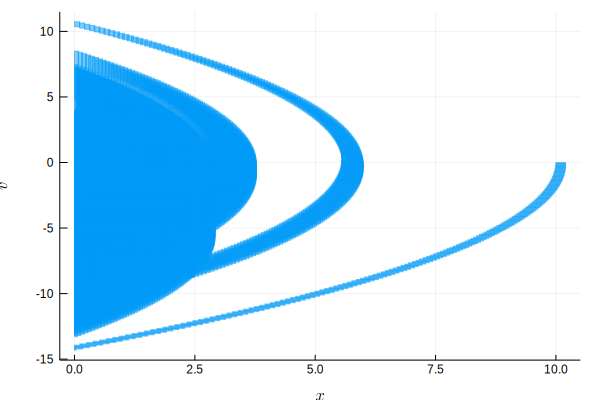

In [56]:
plot(sol, xlab=L"x", ylab=L"v", alpha=.5)

In [17]:
# cargando la data A, R, G, I
using JLD

data = load("data.jld");

┌ Warning: type SparseArrays.SparseVector{Core.Float64,Core.Int64} not present in workspace; reconstructing
└ @ JLD /Users/forets/.julia/packages/JLD/1BoSz/src/jld_types.jl:703


MethodError: MethodError: Cannot `convert` an object of type getfield(JLD, Symbol("##SparseArrays.SparseVector{Core.Float64,Core.Int64}#367")) to an object of type AbstractArray{Float64,1}
Closest candidates are:
  convert(::Type{AbstractArray{T,N}}, !Matched::FillArrays.Fill{T,N,Axes} where Axes) where {T, N} at /Users/forets/.julia/packages/FillArrays/V3jdL/src/FillArrays.jl:71
  convert(::Type{AbstractArray{T,N}}, !Matched::FillArrays.Zeros{T,N,Axes} where Axes) where {T, N} at /Users/forets/.julia/packages/FillArrays/V3jdL/src/FillArrays.jl:176
  convert(::Type{AbstractArray{T,N}}, !Matched::FillArrays.Ones{T,N,Axes} where Axes) where {T, N} at /Users/forets/.julia/packages/FillArrays/V3jdL/src/FillArrays.jl:176
  ...

In [ ]:
# Let:

using Revise, LazySets, Plots


V = VPolygon([[0.598462, -14.2245], [5.66611e-8, -14.2245], [5.66611e-8, -14.715], [0.114707, -14.715],
          [0.598462, -14.2312]])
Vh = tohrep(V)

ε = 0.0

G = HPolyhedron([HalfSpace([0.0, 1.0], 0.0), # v ≤ 0
                 HalfSpace([-1.0, 0.0], ε),  # x ≥ 0
                 HalfSpace([1.0, 0.0], ε)])  # x ≤ 0
plot(V)

In [ ]:
using Polyhedra, GLPKMathProgInterface

In [ ]:
# Problem: `isempty` and `vertices_list` / `overapproximate` give contradictory answers.

is_intersection_empty(G, V)

In [ ]:
is_intersection_empty(G, Vh)

In [ ]:
intersection(G, Vh)

In [ ]:
Q = HPolytope([constraints_list(G); constraints_list(Vh)])
remove_redundant_constraints!(Q, backend=GLPKSolverLP())

In [ ]:
Q.constraints

In [ ]:
# x <= 0
# 2.77e-8 <= 0.4905 * x

In [ ]:
2.7792269549999944e-8 / 0.4905

In [ ]:
# x >= 5.6661099999999887e-8

In [ ]:
# De estas dos, que x <= 0 y x >= 5e-8, deberia deducir que se cumple x = 0

# el problema es que la funcion vertices list es estricta y no me devuelve eso. . . . en cambio
# devuelve que la lista de vertices es cero

# si fuera estricto es verdad, pero la idea seria agregar un geq y un leq

In [ ]:
vertices_list(Q)

In [ ]:
# miremos las ecuaciones para y:
# 0.598462 * y <= -8.512821913024183  
# y <= -14.224498653254814

#  -0.114707 * y <= 1.6879126712319135
# y >= -14.714992731323402

# se concluye que -14.714992731323402 <= y <= -14.224498653254814
# por tanto tampoco esta vacio

In [ ]:
# lo que queda por ver es como "arreglar" vertices list para que no de cero en este caso

In [ ]:
vertices_list(Q)

In [ ]:
Q.constraints

In [ ]:
# vemos que CDDLib si funciona bien!

In [ ]:
using CDDLib

In [ ]:
vertices_list(Q, backend=CDDLib.Library())

In [ ]:
# comparar con
vertices_list(Q, backend=LazySets.default_polyhedra_backend(Q, Float64))

In [ ]:
# por otro lado, lo que estaria bueno es que tambien HPolygon funcione en estos casos
# EN MASTER NO FUNCIONA PERO HACIENDO LOS CAMBIOS DE _leq en membership y haciendo mas grande ztol, funciona!
# por otro lado tengo que hacer dos cambios mas:
# hacer CDDLib default
# hacer vertices list con polygons default en 2D incluso si es un HPolytope. . .
Qhp = convert(HPolygon, Q)
vertices_list(Qhp)

In [ ]:
vertices_list(Qhp, false, false)

In [ ]:
vertices_list(Qhp)

In [ ]:
points = Array{Float64,1}[[0.0, -14.2245], [5.66611e-8, -14.2245], [5.66611e-8, -14.715], [0.0, -14.715]]
avg = sum(points) / length(points)
avg ∈ Qhp

In [ ]:
isapproxzero(2.833055e-8, ztol=sqrt(eps(Float64)) * 10)

In [ ]:
sqrt(eps(Float64)) * 10

In [ ]:
using LazySets: _leq, _geq, _isapprox, isapproxzero

x = 2.833055e-8
y = 0.0

In [ ]:
_leq(x, y)

In [ ]:
nztol=sqrt(eps(Float64)) * 10
_leq(x, y, ztol=nztol)

In [ ]:
_isapprox(1e-8, 1e-7)

In [ ]:
_leq(1.0e-8, 2.833055e-8)

In [ ]:
?LazySets._geq

In [ ]:
convex_hull(Array{Float64,1}[[0.0, -14.2245], [5.66611e-8, -14.2245], [5.66611e-8, -14.715], [0.0, -14.715]])

In [ ]:
vertices_list(intersection(G, Vh))

In [ ]:
vertices_list(ans)

In [ ]:
convex_hull(vertices_list(convert(HPolygon, intersection(G, V))))

In [ ]:
overapproximate(G ∩ V, OctDirections)

In [59]:
# that's the intersection between a half-space and a linear map

# the halfspace is the invariant x >= 0
I = HalfSpace([-1.0, 0.0], 0.0)

# the coefficient's matrix of the linear map is the assignment
A = [1.0 0.0; 0.0 -0.75]

# the set wrapped by the linear map is a lazy intersection between a polytope and a polyhedron
# one can see that the polytope corresponds to the reach set and that the polyhedron corresponds 
# to the guard set
# the polytope is  println(A⌜R⋂G⌟⋂I.Y.X.X)
# the polyhedron is  println(A⌜R⋂G⌟⋂I.Y.X.Y)
R = HPolyhedron([HalfSpace([1.0, 1.0], -13.626037500000011),
HalfSpace([1.0, -1.0], 14.829706875000008),
HalfSpace([-1.0, 1.0], -14.224500059337577),
HalfSpace([-1.0, -1.0], 14.714999990399326),
HalfSpace([1.0, 0.0], 0.5984624999999967),
HalfSpace([0.0, 1.0], -14.224500000000008),
HalfSpace([0.0, -1.0], 14.715000000000012),
HalfSpace([-1.0, 0.0], -5.666114613038476e-8)])

ε = zero(Float64)
G = HPolyhedron([HalfSpace([0.0, 1.0], 0.0),   # v ≤ 0
                 HalfSpace([-1.0, 0.0], 0.0),  # x ≥ 0
                 HalfSpace([1.0, 0.0], 0.0)])  # x ≤ 0

HPolyhedron{Float64}(HalfSpace{Float64}[HalfSpace{Float64}([0.0, 1.0], 0.0), HalfSpace{Float64}([-1.0, 0.0], 0.0), HalfSpace{Float64}([1.0, 0.0], 0.0)])

false

In [60]:
isempty(A * (R ∩ G ) ∩ I)

false

In [61]:
isempty(A * (convert(HPolytope, R) ∩ G ) ∩ I)

ErrorException: the intersection is empty

Problema: funciona con HPolyhedron pero no con HPolytopen

In [64]:
isempty(A * overapproximate(R ∩ G, OctDirections(2)) ∩ I)

MethodError: MethodError: LazySets.Approximations.overapproximate(::Intersection{Float64,HPolyhedron{Float64},HPolyhedron{Float64}}, ::OctDirections{Float64}) is ambiguous. Candidates:
  overapproximate(cap::Intersection{N,#s35,#s24} where #s24<:LazySet where #s35<:AbstractPolyhedron{N}, dir::LazySets.Approximations.AbstractDirections{N}) where N<:Real in LazySets.Approximations at /Users/forets/.julia/dev/LazySets/src/Approximations/overapproximate.jl:442
  overapproximate(cap::Intersection{N,#s35,#s24} where #s24<:AbstractPolyhedron{N} where #s35<:LazySet, dir::LazySets.Approximations.AbstractDirections{N}) where N<:Real in LazySets.Approximations at /Users/forets/.julia/dev/LazySets/src/Approximations/overapproximate.jl:432
Possible fix, define
  overapproximate(::Intersection{N<:Real,#s35,#s24} where #s24<:AbstractPolyhedron{N<:Real} where #s35<:AbstractPolyhedron{N<:Real}, ::LazySets.Approximations.AbstractDirections{N<:Real})

In [66]:
P = rand(HPolyhedron)
overapproximate(P ∩ P, OctDirections(2))

MethodError: MethodError: LazySets.Approximations.overapproximate(::Intersection{Float64,HPolyhedron{Float64},HPolyhedron{Float64}}, ::OctDirections{Float64}) is ambiguous. Candidates:
  overapproximate(cap::Intersection{N,#s35,#s24} where #s24<:LazySet where #s35<:AbstractPolyhedron{N}, dir::LazySets.Approximations.AbstractDirections{N}) where N<:Real in LazySets.Approximations at /Users/forets/.julia/dev/LazySets/src/Approximations/overapproximate.jl:442
  overapproximate(cap::Intersection{N,#s35,#s24} where #s24<:AbstractPolyhedron{N} where #s35<:LazySet, dir::LazySets.Approximations.AbstractDirections{N}) where N<:Real in LazySets.Approximations at /Users/forets/.julia/dev/LazySets/src/Approximations/overapproximate.jl:432
Possible fix, define
  overapproximate(::Intersection{N<:Real,#s35,#s24} where #s24<:AbstractPolyhedron{N<:Real} where #s35<:AbstractPolyhedron{N<:Real}, ::LazySets.Approximations.AbstractDirections{N<:Real})

In [ ]:
plot(sol.Xk[2].X, xlab=L"x", ylab=L"v", alpha=.5)

In [ ]:
plot(sol, xlab=L"x", ylab=L"v", alpha=.5)

## Debugging 'intersection is empty'

In [ ]:
# first lets copmute the flowpipe before the jump


In [ ]:
length(sol.Xk)

In [ ]:
M = []
for i in eachindex(sol.Xk)
    vlist = convex_hull(vertices_list(sol.Xk[i].X))
    vlist = [vlist; vlist[1, :]] # close the polygon
    push!(M, Matrix(hcat(vlist...)'))
end;

In [ ]:
# ==============================
# FOR WRITING
# ==============================
M = []
for i in eachindex(sol.Xk)
    vlist = convex_hull(vertices_list(sol.Xk[i].X))
    vlist = [vlist; vlist[1, :]] # close the polygon
    push!(M, Matrix(hcat(vlist...)'))
end;

matwrite("flowpipe2.mat", Dict("M"=>M))

# ==============================
# FOR READING
# ==============================
v = matread("flowpipe2.mat")["M"]

vi = v[1]
fig = plot(VPolygon([vi[j, 1:2] for j in 1:size(vi, 1)]), color="lightblue")
for i in 2:length(v)
    vi = v[i]
    plot!(fig, VPolygon([vi[j, 1:2] for j in 1:size(vi, 1)]), color="lightblue")
end
fig

In [ ]:
v = matread("flowpipe.mat")["M"]

vi = v[1]
fig = plot(VPolygon([vi[j, 1:2] for j in 1:size(vi, 1)]), color="lightblue")
for i in 2:length(v)
    vi = v[i]
    plot!(fig, VPolygon([vi[j, 1:2] for j in 1:size(vi, 1)]), color="lightblue")
end
fig

In [ ]:
function fourrandom()
    return rand(1:10,4)
end

open("t.txt", "w") do f
   for i in 1:20
      n1, n2, n3, n4 = fourrandom()
      write(f, "$M \n")
   end
end

In [ ]:
using MAT

In [ ]:
matwrite("matfile.mat", Dict(
	"myvar1" => 0,
	"myvar2" => 1
))

In [ ]:
# just checking the flowpipe for the "falling" mode:

# falling : x' = Ax + b, x ∈ X
A = [0.0 1.0;
     0.0 0.0]

b = [0.0,
    -9.81]

problem = IVP(AffineContinuousSystem(A, b), X0)
options = Options(:mode=>"reach", :T=>10., :plot_vars=>[1, 2])

# produces box flowipe
sol = solve(problem, options, op=BFFPSV18(:δ=>1.0));

using LazySets.Approximations

# produces box flowipe -- not too accurate, compare w/zonotopes 
#sol = solve(problem, options, op=BFFPSV18(:δ=>0.1));

# should produce octagons -- doesn't work !
#sol = solve(problem, options, op=BFFPSV18(:δ=>0.01, :partition=>[1:2],
#            :block_options=>OctDirections));

# use zonotope-based algorithm
@time sol = solve(problem, options, op=GLGM06(:δ=>0.1, :max_order=>2));

In [ ]:
plot([sol.Xk[i].X for i in eachindex(sol.Xk)], alpha=.5, color=:lightblue)

In [ ]:
s = IVP(BouncingBall.s.modes[1], X0)
opts = Options(:mode=>"reach", :T=>T, :plot_vars=>[1, 2],
               :project_reachset=>true, :set_type_proj=>HPolygon)
optsC = BFFPSV18(:δ=>0.02, :partition=>[1:2], :block_options=>OctDirections)
sol = solve(s, opts, op=optsC);

In [ ]:
plot(sol, xlab="x1", ylab="y")

## Solution using Zonotopes

In [ ]:
# quick fix to convert polytope to zonotope:
# overapproximate the polytope with a box and convert to zonotope
using LazySets.Approximations: overapproximate
import Base.convert

convert(::Type{Zonotope}, P::HPolytope) = convert(Zonotope, overapproximate(P, Hyperrectangle))

In [ ]:
@time begin
    opts = merge!(Options(:max_jumps=>3, :project_reachset=>false,
                          :set_type_proj=>HPolygon, :verbosity=>1), options)
    opC = GLGM06(:δ=>0.05, :max_order=>2)
    opD = LazyDiscretePost(:check_invariant_intersection=>true,
                           :lazy_R⋂I=>false, :overapproximation=>OctDirections)
    
    sol = solve(BouncingBall, opts, opC, opD)
end;

In [ ]:
using Polyhedra

In [ ]:
plot(sol, alpha=.5)